In [1]:
%%capture
!pip install einops
!pip install anomalib
!pip install lightning
!pip install FrEIA
!pip install open_clip_torch
!pip install dotenv
!pip install python-dotenv
!pip install kornia

In [2]:
!pip install torchvision timm imgaug openvino git+https://github.com/open-edge-platform/anomalib.git

  Cloning https://github.com/open-edge-platform/anomalib.git to /tmp/pip-req-build-kb1jgcvq
  Running command git clone --filter=blob:none --quiet https://github.com/open-edge-platform/anomalib.git /tmp/pip-req-build-kb1jgcvq
  Resolved https://github.com/open-edge-platform/anomalib.git to commit 9887e1e6d302486d17419486c237e3e66e377dc0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 MB 19.2 MB/s eta 0:00:00
  Created wheel for anomalib: filename=anomalib-2.1.0.dev0-py3-none-any.whl size=726769 sha256=d8c57f396b5ccca20a6b39ed3a6d1d14eabe3ef0de46e0ec452c54803f6d79d9
  Stored in directory: /tmp/pip-ephem-wheel-cache-0z02ibzn/wheels/9a/48/eb/3d0764990a89fd2162b60e48f6ef6903a0ef14102f5cfbbf65
Successfully built anomalib
  Attempting uninstall: anomalib
    Found existing 

In [3]:
!pip install python-dotenv

In [ ]:
from anomalib.models import Padim
from anomalib.data.utils import read_image
import os
import shutil
from PIL import Image
from tqdm import tqdm
from pathlib import Path
import torch
from torchvision.transforms import ToTensor
from torchvision import transforms
from anomalib.deploy import TorchInferencer
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
#plt.use('Agg')
%matplotlib inline
#plt.ion()
import numpy as np
from torchvision.utils import make_grid
from anomalib.data import Folder
from anomalib.models import Patchcore
from anomalib.engine import Engine
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from IPython.display import display

In [6]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [13]:
DATASET_PATH = "/content/gdrive/MyDrive/wood_dataset/wood"
NORMAL_DIR = os.path.join(DATASET_PATH, "normal_data")
TEST_DIR = os.path.join(DATASET_PATH, "test/normal_data")
ABNORMAL_DIR = os.path.join(DATASET_PATH, "anormal_data")
MASK_DIR = os.path.join(DATASET_PATH, "mask/anormal_data")
OUTPUT_DIR = "content/gdrive/padim_results"
#IMAGENET_DIR = "./datasets/imagenette"  # ImageNet veri seti yolu
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [15]:
from anomalib.data.datamodules.image.folder import Folder
# from anomalib.data.utils import TestSplitMode
from anomalib import TaskType

datamodule = Folder(
  name="wood_data",
	root=DATASET_PATH,
	normal_dir="/content/gdrive/MyDrive/wood_dataset/wood/train/good",
  abnormal_dir="/content/gdrive/MyDrive/wood_dataset/wood/test/defect",
  mask_dir="/content/gdrive/MyDrive/wood_dataset/wood/ground_truth/defect",
	normal_split_ratio=0.2,

	train_batch_size=4,
	eval_batch_size=4,

)
datamodule.setup()

In [18]:
model = Padim(
    backbone="resnet18",
    layers=['layer1', 'layer2', 'layer3'],
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [19]:
engine = Engine(
    max_epochs=3,
    default_root_dir=OUTPUT_DIR
)

In [20]:
engine.train(
    datamodule=datamodule,
    model=model
)

print("Eğitim tamamlandı! Sonuçlar {} klasöründe.".format(OUTPUT_DIR))

INFO:lightning_fabric.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning_fabric.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning_fabric.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:lightning_fabric.utilities.rank_zero:`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
INFO: 
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | pre_processor  | PreProcessor  | 0      | train
1 | post_processor | PostProcessor | 0      | train
2 | evaluator      | Evaluator     | 0      | train
3 | model          | PadimModel 

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning_fabric.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor, PreProcessor
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.8650793433189392     │
│       image_F1Score       │    0.9459459185600281     │
│        pixel_AUROC        │    0.9095631837844849     │
│       pixel_F1Score       │    0.32465898990631104    │
└───────────────────────────┴───────────────────────────┘

Eğitim tamamlandı! Sonuçlar content/gdrive/padim_results klasöründe.


In [ ]:
predictions = engine.predict(model=model,datamodule=datamodule)

INFO:lightning_fabric.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor, PreProcessor
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Predicting: |          | 0/? [00:00<?, ?it/s]

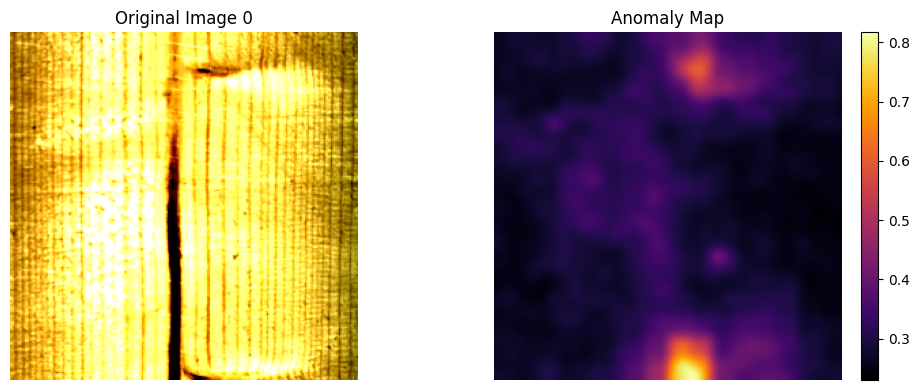

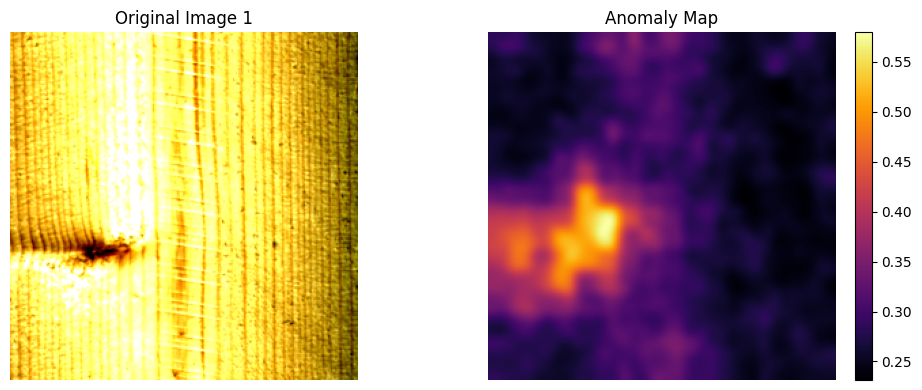

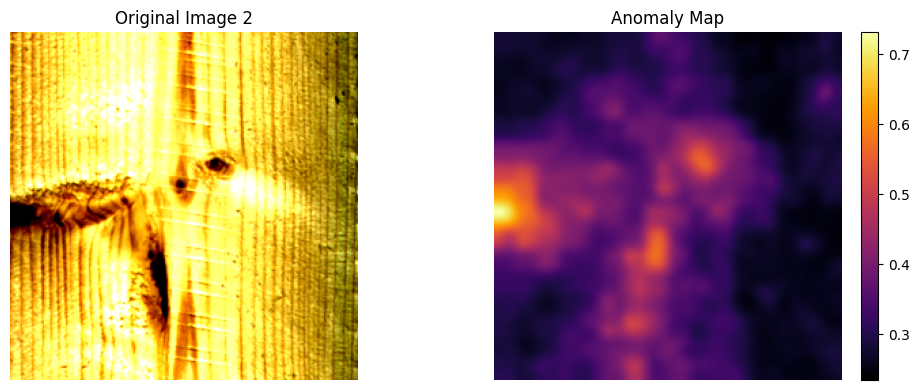

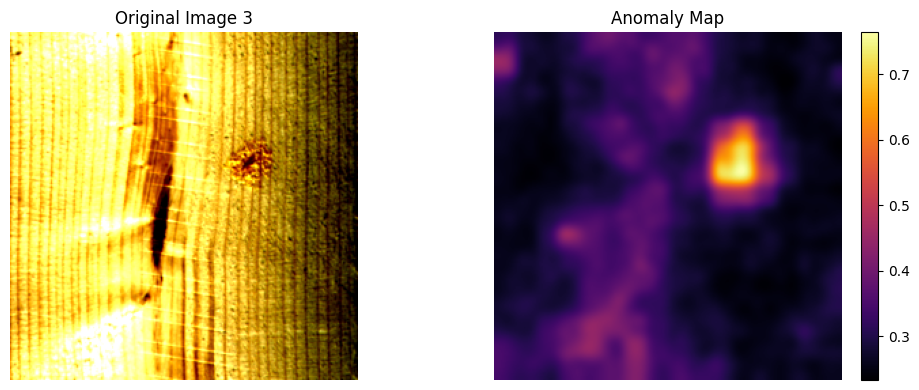

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# prediction içerisinden image ve anomaly map'i al
images = predictions[0].image.cpu().numpy()              # [B, C, H, W]
anomaly_maps = predictions[0].anomaly_map.cpu().numpy()  # [B, 1, H, W]

batch_size = images.shape[0]

for idx in range(batch_size):
    img = images[idx]
    img_rgb = np.transpose(img, (1, 2, 0))         # [C, H, W] -> [H, W, C]
    img_rgb = np.clip(img_rgb, 0, 1)

    heatmap = anomaly_maps[idx].squeeze()          # [1, H, W] -> [H, W]

    # Yan yana iki subplot
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    axs[0].imshow(img_rgb)
    axs[0].set_title(f"Original Image {idx}")
    axs[0].axis("off")

    im = axs[1].imshow(heatmap, cmap="inferno")
    axs[1].set_title("Anomaly Map")
    axs[1].axis("off")

    fig.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()
